In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt

import mlxtend # library to plot the confusion matrix
!pip install mlxtend --upgrade --no-deps

from sklearn.preprocessing import StandardScaler

import scipy.stats as stats

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

print('Libraries imported.')

Requirement already up-to-date: mlxtend in /usr/local/lib/python3.6/dist-packages (0.18.0)
Libraries imported.


In [4]:
# path = '/content/drive/MyDrive/Python/Redes Neuronales Convolucionales/Human Activity Recognition/CNN V1/dataset/WISDM_ar_v1.1_raw.txt'
# data_raw = pd.read_csv(path,                        # dataset's path
#                        header = None,               # raw dataset has no headers
#                        lineterminator = ";",        # the final column ends with ";"
#                        engine = "c",                # Parser engine "c" is faster than python parser engine
#                        error_bad_lines = False,     # irregularities in the dataset like the numbers of columns not match
#                        sep = ',',
#                        low_memory = False
#                        )

In [5]:
data_har = data_raw.copy()
data_har.drop([0, 2], axis = 1, inplace = True)
data_har.columns = ['Activity', 'Ax', 'Ay', 'Az']
data_har.head()
data_har.dropna(axis = 0, how = 'any', inplace = True)
data_har.reset_index(drop = True, inplace = True)
print('Rows: {}'.format(data_har.shape[0]))
print('Columns: {}'.format(data_har.shape[1]))
data_har.head()

Rows: 1086474
Columns: 4


,Activity,Ax,Ay,Az
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [6]:
for column in data_har.columns:
    print('{} --> {}'.format(column, data_har[column].dtype))

Activity --> object
Ax --> float64
Ay --> float64
Az --> float64


In [7]:
data_har['Activity'].value_counts()

Walking       418394
Jogging       336450
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: Activity, dtype: int64

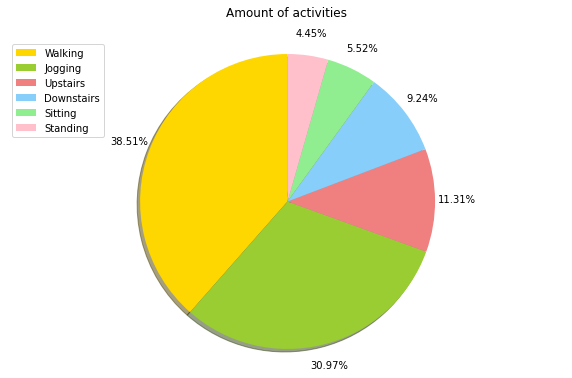

In [8]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0, 0, 0, 0, 0, 0] # ratio for each continent with which to offset each wedge.
labels = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
sizes = []
for size in data_har['Activity'].value_counts():
  sizes.append(size)

fig, ax = plt.subplots(figsize =(10,6))
ax.pie(sizes,
      autopct = '%1.2f%%', 
      startangle = 90,    
      shadow = True,       
      labels = None,         # turn off labels on pie chart
      pctdistance = 1.15,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
      colors = colors_list,  # add custom colors
      explode = explode_list # 'explode' lowest 3 continents
)

# scale the title up by 12% to match pctdistance
plt.title('Amount of activities', y = 1.05) 
plt.axis('equal') 

# add legend
plt.legend(labels = labels, loc = 'upper left') 
plt.show()

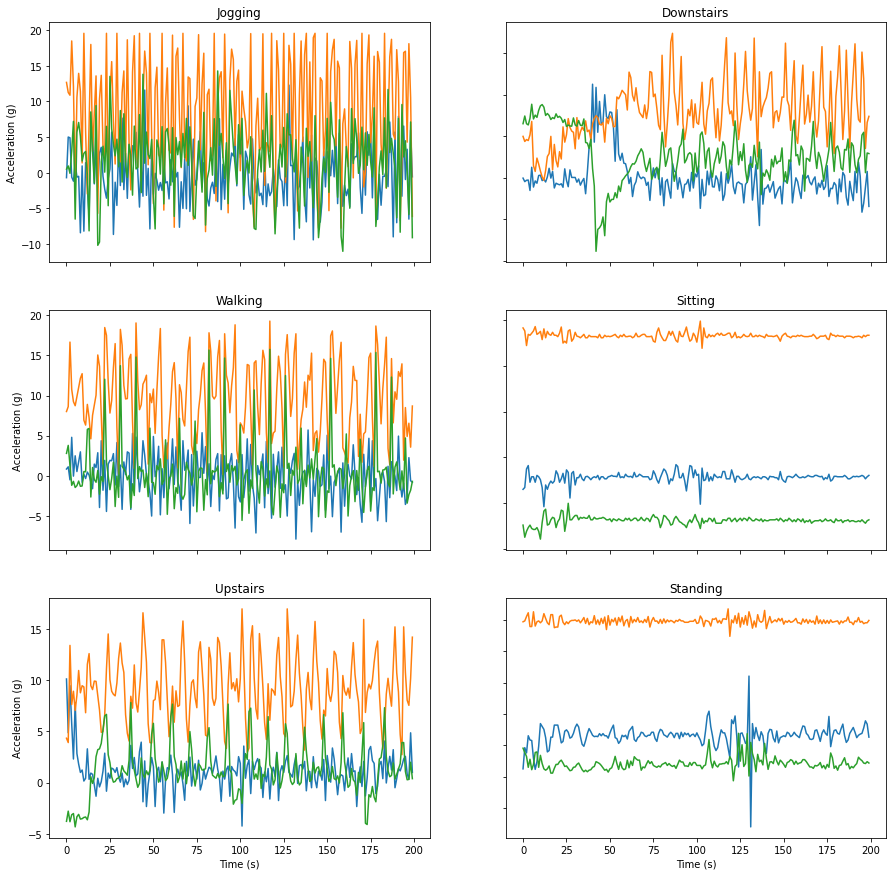

In [9]:
ts = 4  # time to plot
fig, axs = plt.subplots(3, 2, figsize = (15,15))
row = 0
column = 0

for index, activity in enumerate(data_har['Activity'].unique()):
  data_plot = data_har[data_har['Activity'] == activity][:50*ts]
  data_time = np.arange(0,50*ts)
  axs[row,column].plot(data_time, data_plot['Ax'],
                       data_time, data_plot['Ay'],
                       data_time, data_plot['Az'])
  axs[row,column].set_title(activity)

  if (index == 2): column, row   = 1,0
  else: row = row + 1

for ax in axs.flat: ax.set(xlabel='Time (s)', ylabel='Acceleration (g)')
# Hide x labels and tick labels for top plots and y ticks for right plots
for ax in axs.flat: ax.label_outer()

In [92]:
min_ = data_har['Activity'].value_counts().min()
df_walking    = data_har[data_har['Activity'] == 'Walking'   ].head(min_)[:]
df_jogging    = data_har[data_har['Activity'] == 'Jogging'   ].head(min_)[:]
df_upstairs   = data_har[data_har['Activity'] == 'Upstairs'  ].head(min_)[:]
df_downstairs = data_har[data_har['Activity'] == 'Downstairs'].head(min_)[:]
df_sitting    = data_har[data_har['Activity'] == 'Sitting'   ].head(min_)[:]
df_standing   = data_har[data_har['Activity'] == 'Standing'  ].head(min_)[:]
data_bhar = pd.DataFrame()
data_bhar = data_bhar.append([df_walking, df_jogging, df_upstairs, df_downstairs, df_sitting, df_standing])
data_bhar.reset_index(drop = True, inplace = True)

Color channel

In [16]:
def get_frames(data_norm, frame_size, padding):
  nf = 3 # number of input features (ax, ay, az) 
  min_sample = data_norm['Activity'].value_counts().min()
  frames = []
  activities = []
  labels = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
  for index in labels: # numbers of atributes of the class
    s_atribute = data_norm[data_norm['Activity'] == index] # each atribute
    for i in np.arange(0, min_sample - frame_size, padding):
      ax = s_atribute['Ax'].values[i: i + frame_size]
      ay = s_atribute['Ay'].values[i: i + frame_size]
      az = s_atribute['Az'].values[i: i + frame_size]
      clase = stats.mode(s_atribute['Activity'][i: i + frame_size])[0][0]
      frames.append([ax, ay, az])
      activities.append(clase)
  frames = np.asarray(frames).reshape(-1, frame_size, nf)
  activities = np.asarray(activities)
  return frames, activities

In [17]:
#Preparing dataset (Frames)
fs = 20 # sample frequency 20 Hz each sample (50 ms), that means, 20 samples =  1 s
ts = 4  # sample time (window size)
frame_size = fs*ts # 80 samples
padding = 20 # how many columns I get a new frame (40, I left a space of 40 columns between each frame)
X, y = get_frames(data_bhar, frame_size, padding)

Converting series dataset into images rgb dataset

In [112]:
def scale(array):
    array_min = array.min()
    array_max = array.max()
    return np.int_((255*(array - np.min(array))/np.ptp(array)))

rgb_data = np.zeros([len(X),3, frame_size, 3], dtype = np.uint8)
for index, sample in enumerate(X):
  for i in np.arange(0,3): #(3 axes (ax, ay, az))
    ax_r = sample[:,i]
    ax_g = (np.int_(ax_r) - ax_r)*1000
    ax_b = (np.int_(ax_g) - ax_g)*1000
    rgb_data[index,i,:,0] = scale(ax_r) # ax acceleration (3 first digits)
    rgb_data[index,i,:,1] = scale(ax_g) # ax acceleration (second 3 first digits)
    rgb_data[index,i,:,2] = scale(ax_b) # ax acceleration (third 3 first digits)

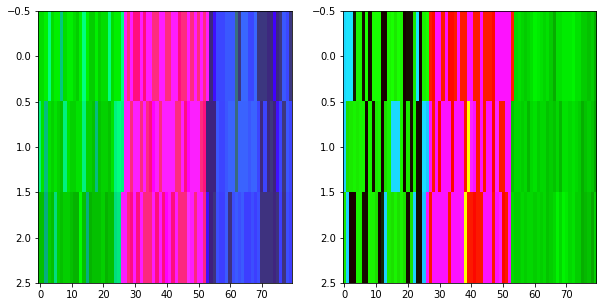

In [113]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

ax0.imshow(rgb_data[14000], aspect = 'auto')
ax1.imshow(rgb_data[13000], aspect = 'auto')
plt.show()

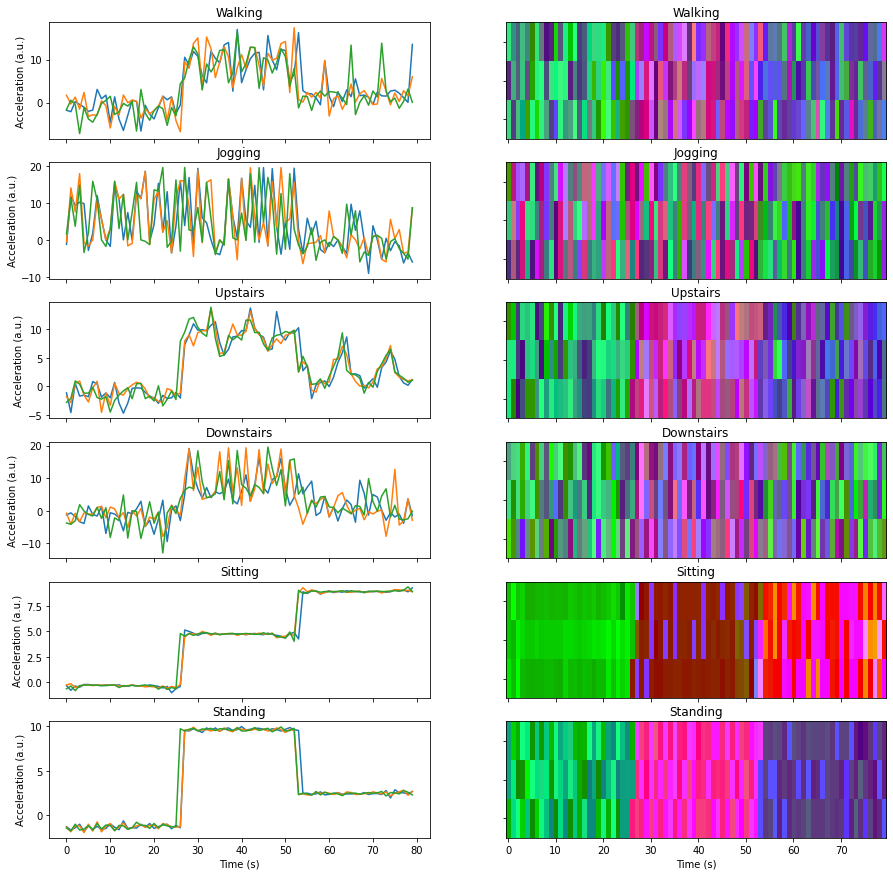

In [114]:
fig, axs = plt.subplots(6, 2, figsize = (15,15))
labels = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
data_time = np.arange(0,80)
for j in np.arange(0,2):
  if (j == 0):
    for index, i in enumerate(np.arange(1208,14496,2416)):
      axs[index,j].plot(data_time, X[i][:,0],
                        data_time, X[i][:,1],
                        data_time, X[i][:,2]
                        )
      axs[index,j].set_title(labels[index])
  if (j == 1):
    for index, i in enumerate(np.arange(1208,14496,2416)):
      axs[index,j].imshow(rgb_data[i], aspect = 'auto')
      axs[index,j].set_title(labels[index])

for ax in axs.flat: ax.set(xlabel='Time (s)', ylabel='Acceleration (a.u.)')
# Hide x labels and tick labels for top plots and y ticks for right plots
for ax in axs.flat: ax.label_outer()

Standardize dataset

In [117]:
#standardize dataset
y = data_bhar['Activity']
scaler = StandardScaler()
rgb_data[0][0,:] = scaler.fit_transform(rgb_data[0][0,:])


data_norm = pd.DataFrame(data = X, columns = ['Ax', 'Ay', 'Az'])
data_norm['Activity'] = y.values
labels = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
data_norm['Activity'] = data_norm['Activity'].replace(labels, [0, 1, 2, 3, 4, 5])


ValueError: ignored

In [ ]:
#standardize dataset
X = data_bhar[['Ax', 'Ay', 'Az']]
y = data_bhar['Activity']
scaler = StandardScaler()
X = scaler.fit_transform(X)
data_norm = pd.DataFrame(data = X, columns = ['Ax', 'Ay', 'Az'])
data_norm['Activity'] = y.values
labels = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
data_norm['Activity'] = data_norm['Activity'].replace(labels, [0, 1, 2, 3, 4, 5])

#Preparing dataset (Frames)
fs = 20 # sample frequency 20 Hz each sample (50 ms), that means, 20 samples =  1 s
ts = 4  # sample time (window size)
frame_size = fs*ts # 80 samples
padding = 20 # how many columns I get a new frame (40, I left a space of 40 columns between each frame)

In [ ]:
def obtener_frames(data_norm, frame_size, padding):
  nf = 3 # number of input features (ax, ay, az) 
  frames = []
  clases = []
  for i in np.arange(0, len(data_norm)-frame_size, padding):
    ax = data_norm['Ax'].values[i: i+frame_size]
    ay = data_norm['Ay'].values[i: i+frame_size]
    az = data_norm['Az'].values[i: i+frame_size]
    #Regresa el valor mas comun de arreglo
    clase = stats.mode(data_norm['Activity'][i: i+frame_size])[0][0]
    frames.append([ax, ay, az])
    clases.append(clase)
  frames = np.asarray(frames).reshape(-1, frame_size, nf)
  clases = np.asarray(clases)
  return frames, clases

In [ ]:
# X, y = obtener_frames(data_norm, frame_size, padding)
# X.shape, y.shape ((7258, 80, 3), (7258,))
# 48394/7258 = 6.668 - si 48394/80 = 604.925 - si 48394*6/40 = 7259

In [ ]:
def get_frames(data_norm, frame_size, padding):
  nf = 3 # number of input features (ax, ay, az) 
  min_sample = data_norm['Activity'].value_counts().min()
  frames = []
  activities = []
  for index in np.arange(0,6): # numbers of atributes of the class
    s_atribute = data_norm[data_norm['Activity'] == index] # each atribute
    for i in np.arange(0, min_sample - frame_size, padding):
      ax = s_atribute['Ax'].values[i: i + frame_size]
      ay = s_atribute['Ay'].values[i: i + frame_size]
      az = s_atribute['Az'].values[i: i + frame_size]
      clase = stats.mode(s_atribute['Activity'][i: i + frame_size])[0][0]
      frames.append([ax, ay, az])
      activities.append(clase)
  frames = np.asarray(frames).reshape(-1, frame_size, nf)
  activities = np.asarray(activities)
  return frames, activities

In [ ]:
X, y = get_frames(data_norm, frame_size, padding)
# min_sample - frame_size = 48395 - 80 = 48315
# padding = 20
# for each atribute or activity I have (48315/20 = 2416 samples)
# total activities (6*2416 samples = 14496 samples = len(X))

Converting series dataset into images rgb dataset

In [ ]:
def scale(array):
    array_min = array.min()
    array_max = array.max()
    return np.int_((255*(array - np.min(array))/np.ptp(array)))

rgb_data = np.zeros([len(X),3, frame_size, 3], dtype = np.uint8)
for index, sample in enumerate(X):
  for i in np.arange(0,3): #(3 axes (ax, ay, az))
    rgb_data[index,i,:,0] = scale(np.int_(sample[:,i]*100)) # ax acceleration (3 first digits)
    rgb_data[index,i,:,1] = scale(abs(np.int_(sample[:,i]*100000))%1000) # ax acceleration (second 3 first digits)
    rgb_data[index,i,:,2] = scale(abs(np.int_(sample[:,i]*100000000))%1000) # ax acceleration (third 3 first digits)

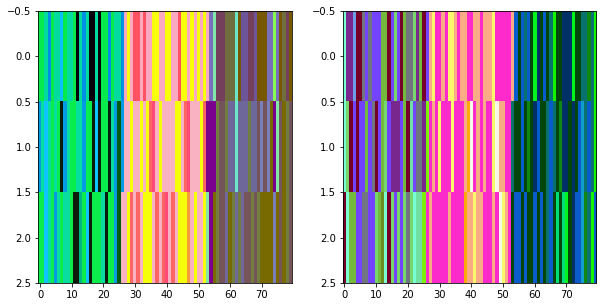

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

ax0.imshow(rgb_data[14000], aspect = 'auto')
ax1.imshow(rgb_data[13000], aspect = 'auto')
plt.show()

Let's plot an example of each activity

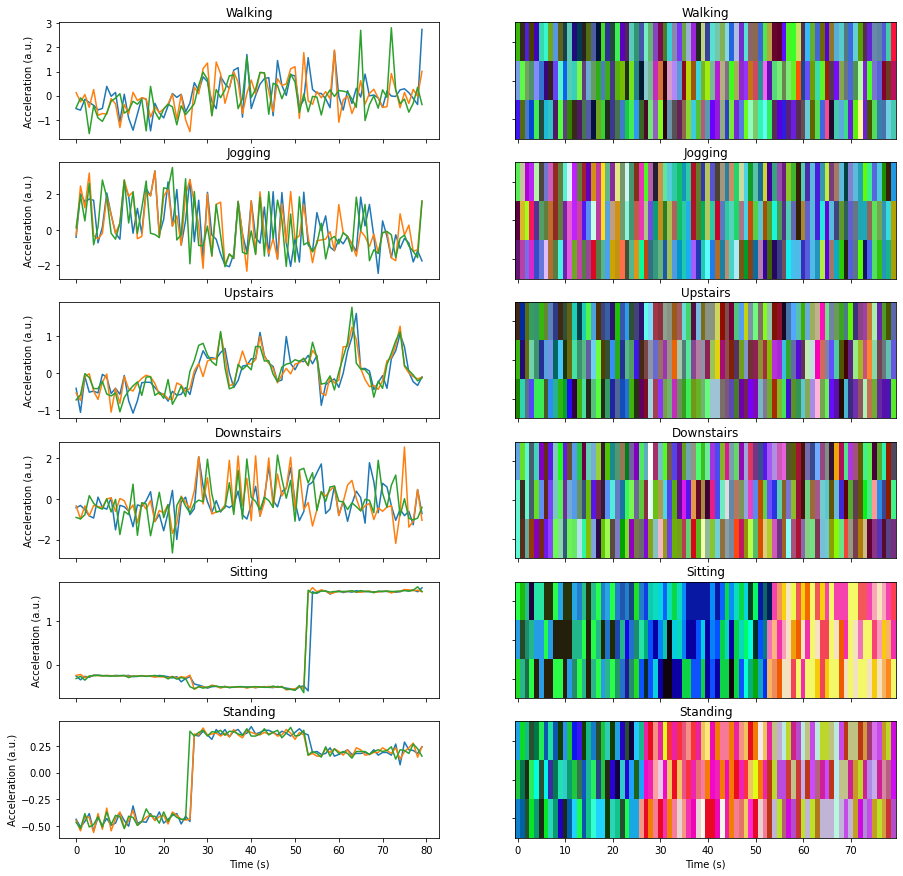

In [ ]:
fig, axs = plt.subplots(6, 2, figsize = (15,15))
labels = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
data_time = np.arange(0,80)
for j in np.arange(0,2):
  if (j == 0):
    for index, i in enumerate(np.arange(1208,14496,2416)):
      axs[index,j].plot(data_time, X[i][:,0],
                        data_time, X[i][:,1],
                        data_time, X[i][:,2]
                        )
      axs[index,j].set_title(labels[index])
  if (j == 1):
    for index, i in enumerate(np.arange(1208,14496,2416)):
      axs[index,j].imshow(rgb_data[i], aspect = 'auto')
      axs[index,j].set_title(labels[index])

for ax in axs.flat: ax.set(xlabel='Time (s)', ylabel='Acceleration (a.u.)')
# Hide x labels and tick labels for top plots and y ticks for right plots
for ax in axs.flat: ax.label_outer()

Model

In [ ]:
# Datos para la CNN

# X, y = obtener_frames(data_norm, frame_size, padding)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = True, stratify = y)
# X_train.shape, X_test.shape
# X_train = X_train.reshape(11612, 80, 3, 1) #numero de muestras, 40x3, profundidad
# X_test = X_test.reshape(2903, 80, 3, 1)

X, y = obtener_frames(data_norm, frame_size, padding)

def scale(array):
    array_min = array.min()
    array_max = array.max()
    return np.int_((255*(array - np.min(array))/np.ptp(array)))

rgb_data = np.zeros([len(X),3, frame_size, 3], dtype = np.uint8)
for index, sample in enumerate(X):
  for i in np.arange(0,3): #(3 axes (ax, ay, az))
    rgb_data[index,i,:,0] = scale(np.int_(sample[:,i]*100)) # ax acceleration (3 first digits)
    rgb_data[index,i,:,1] = scale(abs(np.int_(sample[:,i]*100000))%1000) # ax acceleration (second 3 first digits)
    rgb_data[index,i,:,2] = scale(abs(np.int_(sample[:,i]*100000000))%1000) # ax acceleration (third 3 first digits)

X_train, X_test, y_train, y_test = train_test_split(rgb_data, y, test_size = 0.2, random_state = 0, shuffle = True, stratify = y)
X_train.shape, X_test.shape
X_train = X_train.reshape(11612, 80, 3, 3)
X_test = X_test.reshape(2903, 80, 3, 3)

Creating the model

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(128, (2,2), activation = 'relu', input_shape = X_train[0].shape))
model.add(layers.Conv2D(64, (2,2), activation = 'relu'))
model.add(layers.MaxPooling2D((1, 1)))

model.add(layers.Conv2D(128, (1,1), activation = 'relu'))
model.add(layers.Conv2D(64, (1,1), activation = 'relu'))
model.add(layers.MaxPooling2D((1, 1)))


model.add(layers.Conv2D(64, (1,1), activation = 'relu'))



model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.05))
model.add(layers.Dense(6, activation = 'softmax'))



# model = models.Sequential()
# model.add(layers.Conv2D(128, (2,2), activation = 'relu', input_shape = X_train[0].shape))
# model.add(layers.Conv2D(64, (2,2), activation = 'relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation = 'relu'))
# model.add(layers.Dropout(0.2))
# # model.add(layers.Dense(64, activation = 'relu'))
# # model.add(layers.Dropout(0.2))
# model.add(layers.Dense(6, activation = 'softmax'))

In [ ]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy']
              )
historial = model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), verbose = 2)

Epoch 1/10
363/363 - 12s - loss: 1.1220 - accuracy: 0.6172 - val_loss: 0.6171 - val_accuracy: 0.7520
Epoch 2/10
363/363 - 12s - loss: 0.6094 - accuracy: 0.7397 - val_loss: 0.5533 - val_accuracy: 0.7289
Epoch 3/10
363/363 - 11s - loss: 0.5287 - accuracy: 0.7759 - val_loss: 0.4729 - val_accuracy: 0.8074
Epoch 4/10
363/363 - 11s - loss: 0.4367 - accuracy: 0.8188 - val_loss: 0.3849 - val_accuracy: 0.8440
Epoch 5/10
363/363 - 11s - loss: 0.3512 - accuracy: 0.8538 - val_loss: 0.3603 - val_accuracy: 0.8533
Epoch 6/10
363/363 - 11s - loss: 0.2938 - accuracy: 0.8828 - val_loss: 0.3095 - val_accuracy: 0.8805
Epoch 7/10
363/363 - 11s - loss: 0.2266 - accuracy: 0.9104 - val_loss: 0.2911 - val_accuracy: 0.8874
Epoch 8/10
363/363 - 11s - loss: 0.1980 - accuracy: 0.9243 - val_loss: 0.3050 - val_accuracy: 0.8874
Epoch 9/10
363/363 - 12s - loss: 0.1629 - accuracy: 0.9370 - val_loss: 0.3164 - val_accuracy: 0.8977
Epoch 10/10
363/363 - 12s - loss: 0.1434 - accuracy: 0.9449 - val_loss: 0.3360 - val_accura

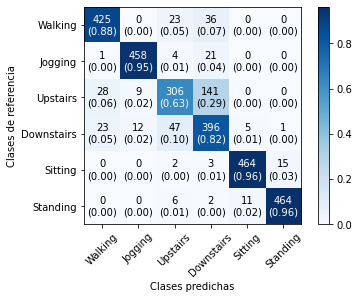

In [ ]:
# Matriz de confusion
y_pred = np.argmax(model.predict(X_test), axis=-1)
#y_pred = model.predict_classes(X_test)
mat = confusion_matrix(y_test, y_pred)
class_names = ['class a', 'class b', 'class c', 'class d', 'class d', 'class d']
fig, ax = plot_confusion_matrix(conf_mat = mat,
                                colorbar = True,
                                show_absolute = True, #Para mostrar valores y porcentaje
                                show_normed = True,
                                class_names = labels) #figsize = (4,4))
plt.xlabel('Clases predichas')
plt.ylabel('Clases de referencia')
plt.show()

### Tests

In [ ]:
ax = X[0][:,0].copy() # ax de la primera muestra (27160 muestras)

In [ ]:
ax.max()

2.8201308321079135

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

arr = np.zeros([1, 10, 3], dtype=np.uint8) # 100 elements of 200 rows x 3 columns

arr[:,:,0] = np.arange(0,10) #same number of rows in red
arr[:,:,1] = np.arange(50,60) #same number of rows in green
arr[:,:,2] = np.arange(100,110) #same number of rows in blue

ax.imshow(arr)
plt.show()
arr

In [ ]:
ax = X[0][:,0].copy()
ax_r = np.int_(ax*100)
ax_g = abs(np.int_(ax*100000))%1000
ax_b = abs(np.int_(ax*100000000))%1000

def scale(array):
    array_min = array.min()
    array_max = arr.max()
    return np.int_((255*(array - np.min(array))/np.ptp(array)))
ax_rs = scale(ax_r)
ax_gs = scale(ax_g)
ax_bs = scale(ax_b)
ax_bs

# len(rgb_) #nrows of a list
# len(rgb_[0]) #columns of a list

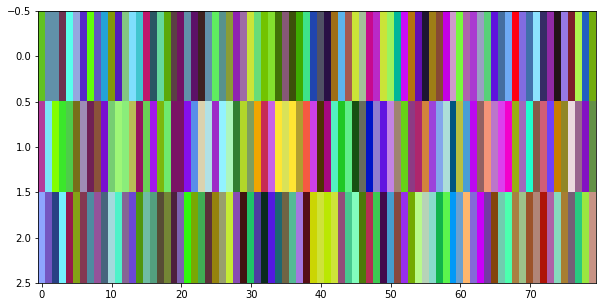

In [ ]:
def scale(array):
    array_min = array.min()
    array_max = array.max()
    return np.int_((255*(array - np.min(array))/np.ptp(array)))

rgb_ = np.zeros([1, 80, 3])
for index in np.arange(0,3):
  rgb_[:,:,index] = X[0][:,index]

acc_x = np.zeros([3, 80, 3], dtype = np.uint8)
# for i in np.arange(0,3):
#   for j in np.arange(0,3):
#     if(i == 0): acc_x[0,:,j] = scale(np.int_(rgb_[0][:,0]*100))
#     if(i == 1): acc_x[0,:,j] = scale(abs(np.int_(rgb_[0][:,0]*100000))%1000)
#     if(i == 2): acc_x[0,:,j] = scale(abs(np.int_(rgb_[0][:,0]*100000000))%1000)

acc_x[0,:,0] = scale(np.int_(rgb_[0][:,0]*100))
acc_x[0,:,1] = scale(abs(np.int_(rgb_[0][:,0]*100000))%1000)
acc_x[0,:,2] = scale(abs(np.int_(rgb_[0][:,0]*100000000))%1000)

acc_x[1,:,0] = scale(np.int_(rgb_[0][:,1]*100))
acc_x[1,:,1] = scale(abs(np.int_(rgb_[0][:,1]*100000))%1000)
acc_x[1,:,2] = scale(abs(np.int_(rgb_[0][:,1]*100000000))%1000)

acc_x[2,:,0] = scale(np.int_(rgb_[0][:,2]*100))
acc_x[2,:,1] = scale(abs(np.int_(rgb_[0][:,2]*100000))%1000)
acc_x[2,:,2] = scale(abs(np.int_(rgb_[0][:,2]*100000000))%1000)

fig, ax = plt.subplots(figsize = (10,5))

ax.imshow(acc_x, aspect = 'auto', cmap = 'viridis')
plt.show()

# acc_x[0,:,0] = np.int_(rgb_*100)
# acc_x[0,:,1] = 
# acc_x[0,:,2] = 

# acc_x[1,:,0] = 
# acc_x[1,:,1] = 
# acc_x[1,:,2] = 



# ax_r = np.int_(rgb_*100)
# ax_g = abs(np.int_(rgb_*100000))%1000
# ax_b = abs(np.int_(rgb_*100000000))%1000

# def scale(array):
#     array_min = array.min()
#     array_max = arr.max()
#     return np.int_((255*(array - np.min(array))/np.ptp(array)))
    

In [ ]:
def scale(array):
    array_min = array.min()
    array_max = array.max()
    return np.int_((255*(array - np.min(array))/np.ptp(array)))

rgb_data = np.zeros([27160,3, 80, 3], dtype = np.uint8)
for index, sample in enumerate(X):
  for i in np.arange(0,3): #(3 axes (ax, ay, az))
    rgb_data[index,i,:,0] = scale(np.int_(sample[:,i]*100)) # ax acceleration (3 first digits)
    rgb_data[index,i,:,1] = scale(abs(np.int_(sample[:,i]*100000))%1000) # ax acceleration (second 3 first digits)
    rgb_data[index,i,:,2] = scale(abs(np.int_(sample[:,i]*100000000))%1000) # ax acceleration (third 3 first digits)

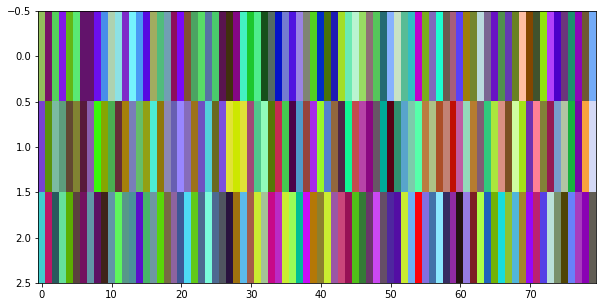

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

ax.imshow(rgb_data[1], aspect = 'auto')
plt.show()

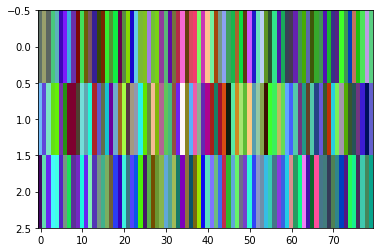

In [ ]:


# r = [  0, 255, 255, 0]  
# g = [255,   0, 255, 0]  
# b = [255, 153,   0, 0] 

# row = 1
# colmn = 4
# rgb = np.zeros([row, colmn, 3], dtype = np.uint8)
# rgb_ = np.transpose([[r],[g],[b]])

# rgb[:,0] = rgb_[0] 
# rgb[:,1] = rgb_[1] 
# rgb[:,2] = rgb_[2] 
# rgb[:,3] = rgb_[3] 
# #*********************************


# row = 1
# colmn = 80
# r = scale(np.int_(X[0][:,0]*100)) # ax acceleration (3 first digits)
# g = scale(abs(np.int_(X[0][:,0]*100000))%1000) # ax acceleration (second 3 first digits)
# b = scale(abs(np.int_(X[0][:,0]*100000000))%1000) # ax acceleration (third 3 first digits)
# rgb = np.zeros([row, colmn, 3], dtype = np.uint8)
# rgb_ = np.transpose([[r],[g],[b]])

# for i in range(0,80):
#   rgb[:,i] = rgb_[i] 


# plt.imshow(rgb, aspect = 'auto' ) # matrix 3 x 2
# plt.show()


row = 3
column = 80
rgb = np.zeros([row, colmn, 3], dtype = np.uint8)

r = scale(np.int_(    X[0][:,0]*100)).reshape((1,80)) # ax acceleration (3 first digits)
g = scale(abs(np.int_(X[0][:,0]*100000))%1000).reshape((1,80)) # ax acceleration (second 3 first digits)
b = scale(abs(np.int_(X[0][:,0]*100000000))%1000).reshape((1,80)) # ax acceleration (third 3 first digits)
ax_ = np.transpose([r,g,b])

r = scale(np.int_(    X[0][:,1]*100)).reshape((1,80)) # ax acceleration (3 first digits)
g = scale(abs(np.int_(X[0][:,1]*100000))%1000).reshape((1,80)) # ax acceleration (second 3 first digits)
b = scale(abs(np.int_(X[0][:,1]*100000000))%1000).reshape((1,80)) # ax acceleration (third 3 first digits)
ay_ = np.transpose([r,g,b])

r = scale(np.int_(    X[0][:,2]*100)).reshape((1,80)) # ax acceleration (3 first digits)
g = scale(abs(np.int_(X[0][:,2]*100000))%1000).reshape((1,80)) # ax acceleration (second 3 first digits)
b = scale(abs(np.int_(X[0][:,2]*100000000))%1000).reshape((1,80)) # ax acceleration (third 3 first digits)
az_ = np.transpose([r,g,b])

for j in np.arange(0, column):
  rgb[0, j] = ax_[j]
for j in np.arange(0, column):
  rgb[1, j] = ay_[j]
for j in np.arange(0, column):
  rgb[2, j] = az_[j]

plt.imshow(rgb, aspect = 'auto' ) # matrix 3 x 2
plt.show()


In [ ]:


# r = [  0, 255, 255, 0]  
# g = [255,   0, 255, 255]  
# b = [255, 153,   0, 0] 

# r2 = [255, 255,   0, 0]  
# g2 = [255,   0, 255, 255]  
# b2 = [  0, 153, 255, 0] 

# row = 2
# colmn = 4
# rgb = np.zeros([row, colmn, 3], dtype = np.uint8)
# rgb_ = np.transpose([[r],[g],[b]])
# rgb2_ = np.transpose([[r2],[g2],[b2]])

# rgb[0,0] = rgb_[0] 
# rgb[0,1] = rgb_[1] 
# rgb[0,2] = rgb_[2] 
# rgb[0,3] = rgb_[3] 

# rgb[1,0] = rgb2_[0] 
# rgb[1,1] = rgb2_[1] 
# rgb[1,2] = rgb2_[2] 
# rgb[1,3] = rgb2_[3] 
# #*********************************


# plt.imshow(rgb, aspect = 'auto' ) # matrix 3 x 2
# rgb_.shape
j